In [1]:
import os
import os.path
import urllib.request
from scipy.integrate import odeint
import torch
from torch import nn, optim
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch


In [2]:
# Fixed random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


In [3]:
# Download dataset from GitHub which was provided by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE).
if not os.path.isfile("./dataset/time_series_19-covid-Confirmed.csv"):
    
    DATASET_NAME = {"time_series_19-covid-Confirmed.csv", "time_series_19-covid-Deaths.csv", "time_series_19-covid-Recovered.csv"}
    for name in DATASET_NAME:
        url = os.path.join("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series", name)
        r = urllib.request.urlretrieve(url, os.path.join("./dataset", name))


In [4]:
# Set train and test in Mathematical, Statistical and Machine learning model
temp_time_series_csv = pd.read_csv(os.path.join("dataset","time_series_19-covid-Confirmed.csv")).iloc[:, 4:].sum(axis=0)
TOTAL_DAYS = int(temp_time_series_csv.shape[0])
print(u"The number of days in the time-series data is {}.".format(TOTAL_DAYS))
## set test size is 14 days
TEST_SIZE = 14
TRAIN_SIZE = int(TOTAL_DAYS - TEST_SIZE)
print(u"We separate time-series data into 2 sets; Train and Test which their size are {} and {} respectively.".format(TRAIN_SIZE, TEST_SIZE))


The number of days in the time-series data is 43.
We separate time-series data into 2 sets; Train and Test which their size are 29 and 14 respectively.


In [5]:
# Set constant values
def set_seir(reproductive_number = 2):
    ## Total of population the world; scr: https://www.worldometers.info/world-population/
    population = 7768726098
    rate_of_brith = 1.05
    print(u"population of the world is {}.".format(population))

    ## recovery rate is the mean of recovered and death cases of the total cases
    _death = pd.read_csv(os.path.join("dataset","time_series_19-covid-Deaths.csv")).iloc[:, 4:].sum(axis=0)
    _death = _death.diff().fillna(_death[0]).astype(np.int64)
    _recovery = pd.read_csv(os.path.join("dataset","time_series_19-covid-Recovered.csv")).iloc[:, 4:].sum(axis=0)
    _recovery = _recovery.diff().fillna(_recovery[0]).astype(np.int64)
    _recovery_and_death = _death + _recovery
    _recovery_and_death = _recovery_and_death.pct_change().fillna("0").astype(np.int64)
    rate_of_recover_and_death = _recovery_and_death.mean()
    print(u"recovery rate is {}.".format(rate_of_recover_and_death))

    ## incubation rate is the mean of confirmed cases of the total cases
    _confirmed = pd.read_csv(os.path.join("dataset","time_series_19-covid-Confirmed.csv")).iloc[:, 4:].sum(axis=0)
    _confirmed = _confirmed.diff().fillna(_confirmed[0]).astype(np.int64)
    _confirmed = _confirmed.pct_change().fillna("0").astype(np.int64)
    rate_of_incubation = _confirmed.mean()
    print(u"incubation rate is {}.".format(rate_of_incubation))

    ## contact rate will calculated by assume that R_0 = 2 then contact rate = R_0 * reconvery rate
    rate_of_contactive =  reproductive_number * rate_of_recover_and_death
    print(u"contact rate is {}.".format(rate_of_contactive))
    return population, rate_of_contactive, rate_of_incubation, rate_of_recover_and_death

def seir_model(day_zero = -1):
    ''' SEIR model without vital dynamics '''
    # I've adapted code from original sorces https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/
    # and https://institutefordiseasemodeling.github.io/Documentation/general/model-seir.html#id11

    # Total population, N; 
    N = population
    # Initial number of infected, exposed and recovered individuals, I0, E0 and R0.
    ## Initial rnumber of recovered cases is the number of recovered plus death cases in the lastest day in the time series 
    ### day_zero = -1 means use the lastest day in the time-series as day 0 of epidemic
    R0 = pd.read_csv(os.path.join("dataset","time_series_19-covid-Deaths.csv")).iloc[:, day_zero].sum(axis=0).astype(np.int64) +\
            pd.read_csv(os.path.join("dataset","time_series_19-covid-Recovered.csv")).iloc[:, day_zero].sum(axis=0).astype(np.int64)
    ## Initial rnumber of infected cases is confirmed minus death and recovered cases in lastest day in the time series 
    I0 = pd.read_csv(os.path.join("dataset","time_series_19-covid-Confirmed.csv")).iloc[:, day_zero].sum(axis=0).astype(np.int64) - R0
    ## assume that confirmed cases is nothing but merely the tip of the iceberg; therefore, let confirmed infected group is ten percent of exposed group.
    E0 = 10 * I0 
    S0 = N - I0 - R0 - E0
    print(u"Initial number of infected, exposed and recovered individuals are {}, {}, and {} respectively.".format(I0, E0, R0))
    print(u"Now, the initial number of susceptible individuals is {}.".format(S0))

    # Average contact rate(beta), incubation rate(alpha) and recovery rate(gamma) (in 1/days); 
    beta = rate_of_contactive
    alpha = rate_of_incubation
    gamma = rate_of_recover_and_death

    # A grid of time points (in days)
    DAYS_TO_PREDICT = 42 + 28 ## use the answer to life the universe and everything + 28 days later
    t = np.linspace(0, DAYS_TO_PREDICT, DAYS_TO_PREDICT)

    # The SIR model differential equations.
    def deriv(y, t, N, alpha, beta, gamma):
        S, E, I, R = y
        dSdt = -beta * S * I / N
        dEdt = beta * S *  I / N - alpha * E
        dIdt = alpha * E - gamma * I
        dRdt = gamma * I
        return dSdt, dEdt, dIdt, dRdt

    # Initial conditions vector
    y0 = S0, E0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, alpha, beta, gamma))
    S, E, I, R = ret.T

    # Plot the data on three separate curves for S(t), I(t) and R(t)
    plt.plot(t, S/1000000, 'b', alpha=0.5, lw=2, label='Susceptible')
    plt.plot(t, E/1000000, 'y', alpha=0.5, lw=2, label='Exposed')
    plt.plot(t, I/1000000, 'r', alpha=0.5, lw=2, label='Infected')
    plt.plot(t, R/1000000, 'g', alpha=0.5, lw=2, label='Recovered with immunity or Death')
    plt.xlabel('days from now')
    plt.ylabel('Number (millionth)')
    plt.grid(b=True, which='major', c='w', lw=2, ls='-')
    plt.legend()
    plt.title("SEIR model")
    plt.savefig("seir_model.jpg")
    plt.show()
    plt.close()

    ## from now on model
    if day_zero != -TEST_SIZE:
        plt.plot(t, I/1000000, 'r', alpha=0.5, lw=2, label='Predicted Infected cases')
        plt.xlabel('days from now')
        plt.ylabel('Number (millionth)')
        plt.legend()
        plt.title("SEIR model for prediction infected cases (future)")
        plt.savefig("future_seir_model.jpg")
        plt.show()
        plt.close()

    else:
        total_confirmed = cases(csv="time_series_19-covid-Confirmed.csv", name="confirmed")[-TEST_SIZE:]
        total_death = cases(csv="time_series_19-covid-Deaths.csv", name="deaths")[-TEST_SIZE:]
        total_recovered = cases(csv="time_series_19-covid-Recovered.csv", name="recovered")[-TEST_SIZE:]
        real_I = total_confirmed - total_death - total_recovered
        plt.plot(real_I.index[:TEST_SIZE], real_I/1000000, 'r', alpha=0.5, lw=2, label='Real Infected cases')
        plt.plot(real_I.index[:TEST_SIZE], I[:TEST_SIZE]/1000000, 'b', alpha=0.5, lw=2, label='Predicted Infected cases')
        plt.xlabel(u'{} days ago to now'.format(TEST_SIZE))
        plt.ylabel('Number (millionth)')
        plt.title("SEIR model for prediction infected cases (validation)")
        plt.xticks(rotation=90)
        plt.legend()
        plt.tight_layout()
        plt.savefig("validation_seir_model.jpg")
        plt.show()
        plt.close()


In [28]:
def cases(csv, name):
    # load dataset
    df = pd.read_csv(os.path.join("dataset",csv))
    #print(df.head())

    # select only time series parts
    df = df.iloc[:, 4:]

    # check missing values
    if df.isnull().sum().sum():
        print("There are missing values, do some thing with them.")

    # get number of cases of the day
    cases = df.sum(axis=0)
    
    # show graph of confirmed cases
    plt.plot(cases)
    plt.title(name+" cases")
    plt.xticks(rotation=45)
    plt.savefig(name+"_cases.jpg")
    #plt.show()
    plt.close()

    # get only number of new cases of the day
    daily_cases = cases.diff().fillna(cases[0]).astype(np.int64)

    # show graph of daily confirmed cases
    plt.plot(daily_cases)
    plt.title("daily "+name+" cases")
    plt.xticks(rotation=45)
    plt.savefig("daily_"+name+"_cases.jpg")
    #plt.show()
    plt.close()

    # show graph of daily and total of the day
    plt.plot(cases, label="Total cases")
    plt.plot(daily_cases, label="Daily cases")
    plt.title("Daily and total "+name+" cases")
    plt.xticks(rotation=45)
    plt.legend()
    plt.savefig("daily_total_"+name+"_cases.jpg")
    #plt.show()
    plt.close()
    
    return cases

def build_lstm(time_series_data, name):
    print("+"*50)
    print(u"Building LSTM model for {} group.".format(name))
    ''' Long-short Term Memory network '''
    ## I've adapted code from original source: https://colab.research.google.com/drive/1nQYJq1f7f4R0yeZOzQ9rBKgk00AfLoS0#scrollTo=iPJMdlBEErg3
    train = time_series_data[:-TEST_SIZE]
    test = time_series_data[-TEST_SIZE:]

    # preprocessing data
    scaler = MinMaxScaler()
    scaler = scaler.fit(np.expand_dims(train, axis=1))
    train = scaler.transform(np.expand_dims(train, axis=1))
    test = scaler.transform(np.expand_dims(test, axis=1))

    def create_sequences(data, seq_length):
        xs = []
        ys = []

        for i in range(len(data)-seq_length-1):
            x = data[i:(i+seq_length)]
            y = data[i+seq_length]
            xs.append(x)
            ys.append(y)

        return np.array(xs), np.array(ys)

    # data preparing
    seq_length = 5
    X_train, y_train = create_sequences(train, seq_length)
    X_test, y_test = create_sequences(test, seq_length)

    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()

    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float()

    # model training
    ## define recurrent neural network architecture
    class CoronaVirusPredictor(nn.Module):

        def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
            super(CoronaVirusPredictor, self).__init__()

            self.n_hidden = n_hidden
            self.seq_len = seq_len
            self.n_layers = n_layers

            self.lstm = nn.LSTM(
                        input_size=n_features,
                        hidden_size=n_hidden,
                        num_layers=n_layers,
                        dropout=0.5
                        )

            self.linear = nn.Linear(in_features=n_hidden, out_features=1)

        def reset_hidden_state(self):
            self.hidden = (
                            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
                        )

        def forward(self, sequences):
            lstm_out, self.hidden = self.lstm(
                                    sequences.view(len(sequences), self.seq_len, -1),
                                    self.hidden
                                    )

            last_time_step = \
                lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]

            y_pred = self.linear(last_time_step)
            return y_pred

    
    ## define training method
    def train_model(model, train, train_labels, test_data=None, test_labels=None):
        loss_fn = torch.nn.MSELoss(reduction='sum')

        optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)
        num_epochs = 120

        train_hist = np.zeros(num_epochs)
        test_hist = np.zeros(num_epochs)

        for t in range(num_epochs):
            model.reset_hidden_state()

            y_pred = model(X_train)

            loss = loss_fn(y_pred.float(), y_train)

            if test_data is not None:
                with torch.no_grad():
                    y_test_pred = model(X_test)
                    test_loss = loss_fn(y_test_pred.float(), y_test)

                test_hist[t] = test_loss.item()

                if t % 10 == 0:  
                    print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')

            elif t % 10 == 0:
                print(f'Epoch {t} train loss: {loss.item()}')

            train_hist[t] = loss.item()
            
            optimiser.zero_grad()

            loss.backward()

            optimiser.step()
        
        return model.eval(), train_hist, test_hist

    ## building step here
    model = CoronaVirusPredictor(n_features=1, n_hidden=512, seq_len=seq_length, n_layers=2)
    model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test)


    # prediction step
    def predict(data_seq, predict_len):
        seq = data_seq
        preds = []
        for _ in range(predict_len):
            y_pred = model(seq)
            pred = torch.flatten(y_pred).item()
            preds.append(pred)
            new_seq = seq.numpy().flatten()
            new_seq = np.append(new_seq, [pred])
            new_seq = new_seq[1:]
            seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

        predicted_cases = scaler.inverse_transform(np.expand_dims(preds, axis=0)).flatten()
        return predicted_cases


    #self_predicted_cases = predict(X_train[:1], TRAIN_SIZE)
    validation_predicted_cases = predict(X_test[:1], TEST_SIZE)
    #validation_predicted_cases = np.append(self_predicted_cases, validation_predicted_cases)
    plt.plot(time_series_data[-TEST_SIZE:]/1000000, label="Real cases")
    plt.plot(validation_predicted_cases/1000000, label="Predicted cases")
    plt.ylabel('Number (millionth)')
    plt.xlabel("14 days ago to now")
    plt.title("LSTM model for "+name+" cases")
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.savefig(name+"_lstm_model_validation.jpg")
    plt.show()
    plt.close()
    
    scaler = MinMaxScaler()
    scaler = scaler.fit(np.expand_dims(time_series_data, axis=1))
    all_data = scaler.transform(np.expand_dims(time_series_data, axis=1))
    
    X_all, y_all = create_sequences(all_data, seq_length)
    X_all = torch.from_numpy(X_all).float()
    y_all = torch.from_numpy(y_all).float()
    
    model = CoronaVirusPredictor(n_features=1, n_hidden=512, seq_len=seq_length, n_layers=2)
    model, train_hist, _ = train_model(model, X_all, y_all)

    DAYS_TO_PREDICT = 42 + 28
    t = np.linspace(0, DAYS_TO_PREDICT, DAYS_TO_PREDICT)
    predicted_cases = predict(X_test[-1:], DAYS_TO_PREDICT)
    plt.plot(t, predicted_cases/1000000, label='Predicted Cases')
    plt.xlabel("days from now")
    plt.ylabel('Number (millionth)')
    plt.title("LSTM model for "+name+" cases")
    plt.legend()
    plt.savefig(name+"_lstm_model.jpg")
    plt.show()
    plt.close()

    return validation_predicted_cases, predicted_cases

def lstm(time_series_data=[], validation_predicted_cases=[], predicted_cases=[]):
    time_series = time_series_data[0] - time_series_data[1] - time_series_data[2]
    validation_cases = validation_predicted_cases[0] - validation_predicted_cases[1] - validation_predicted_cases[2]
    future_cases = predicted_cases[0] - predicted_cases[1] - predicted_cases[2]
    # plot validation graph
    plt.plot(time_series[-TEST_SIZE:]/1000000, label="Real cases")
    plt.plot(validation_cases/1000000, label="Predicted cases")
    plt.ylabel('Number (millionth)')
    plt.xlabel("14 days ago to now")
    plt.title("LSTM model for prediction infected cases (validation)")
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.savefig("validation_lstm_model.jpg")
    plt.show()
    plt.close()

    # plot prediction graph
    DAYS_TO_PREDICT = 42 + 28
    t = np.linspace(0, DAYS_TO_PREDICT, DAYS_TO_PREDICT)
    plt.plot(t, future_cases/1000000, label='Predicted Cases')
    plt.xlabel("days from now")
    plt.ylabel('Number (millionth)')
    plt.title("LSTM model for prediction infected cases (future)")
    plt.legend()
    plt.tight_layout()
    plt.savefig("future_lstm_model.jpg")
    plt.show()
    plt.close()


####################################################################################################
population of the world is 7768726098.
recovery rate is 0.32558139534883723.
incubation rate is 0.9767441860465116.
contact rate is 0.6511627906976745.
Initial number of infected, exposed and recovered individuals are 55775, 557750, and 20424 respectively.
Now, the initial number of susceptible individuals is 7768092149.


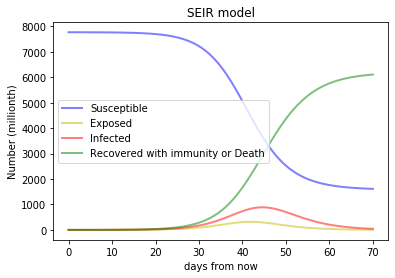

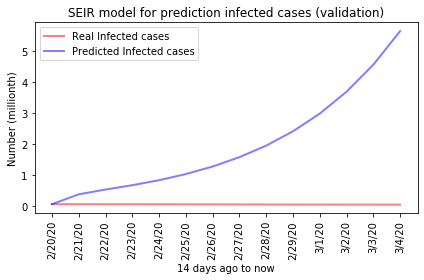

In [16]:
print("#"*100)
# mathematical model; SEIR model, a compartmental models in epidemiology.
population, rate_of_contactive, rate_of_incubation, rate_of_recover_and_death = set_seir(reproductive_number = 2)
seir_model(day_zero = -TEST_SIZE ) ## model from 14 days ago

Initial number of infected, exposed and recovered individuals are 40699, 406990, and 54425 respectively.
Now, the initial number of susceptible individuals is 7768223984.


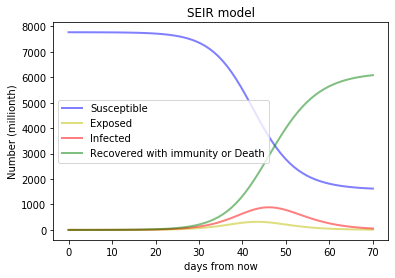

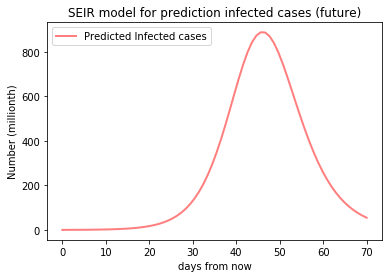

In [17]:
seir_model() ## model from now on

In [18]:
print("#"*100)
# machine learning model; Long-short Term Memory network (as known as LSTM model), a type of recurrent neural network designed model.
total_confirmed = cases(csv="time_series_19-covid-Confirmed.csv", name="confirmed")
total_death = cases(csv="time_series_19-covid-Deaths.csv", name="deaths")
total_recovered = cases(csv="time_series_19-covid-Recovered.csv", name="recovered")


####################################################################################################


++++++++++++++++++++++++++++++++++++++++++++++++++
Building LSTM model for confirmed group.
Epoch 0 train loss: 6.069841384887695 test loss: 9.187206268310547
Epoch 10 train loss: 3.5053882598876953 test loss: 6.275405406951904
Epoch 20 train loss: 2.3231911659240723 test loss: 2.1800286769866943
Epoch 30 train loss: 2.158130645751953 test loss: 3.085911989212036
Epoch 40 train loss: 2.189452648162842 test loss: 3.279482126235962
Epoch 50 train loss: 2.0966076850891113 test loss: 2.3847951889038086
Epoch 60 train loss: 2.10548996925354 test loss: 2.543926477432251
Epoch 70 train loss: 2.0319948196411133 test loss: 2.0699965953826904
Epoch 80 train loss: 1.9238011837005615 test loss: 1.489614725112915
Epoch 90 train loss: 1.770575761795044 test loss: 0.28651806712150574
Epoch 100 train loss: 1.4378697872161865 test loss: 9.176312446594238
Epoch 110 train loss: 1.3489803075790405 test loss: 155.0716552734375


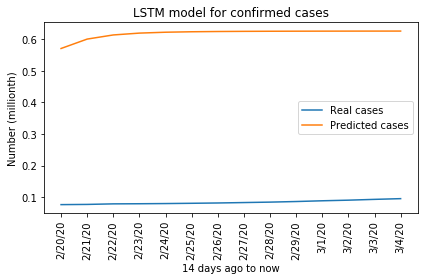

Epoch 0 train loss: 6.424593925476074
Epoch 10 train loss: 3.6624269485473633
Epoch 20 train loss: 2.318418502807617
Epoch 30 train loss: 2.1583542823791504
Epoch 40 train loss: 2.1816163063049316
Epoch 50 train loss: 2.112217664718628
Epoch 60 train loss: 2.105858087539673
Epoch 70 train loss: 2.0692338943481445
Epoch 80 train loss: 1.9180798530578613
Epoch 90 train loss: 1.8179666996002197
Epoch 100 train loss: 1.4427218437194824
Epoch 110 train loss: 1.2902754545211792


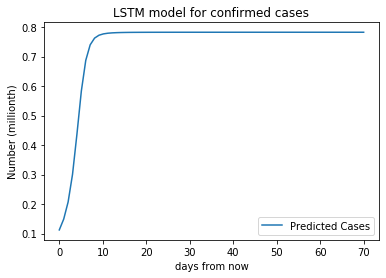

In [29]:
confirmed_validation_predicted_cases, confirmed_predicted_cases = build_lstm(total_confirmed, name="confirmed")

++++++++++++++++++++++++++++++++++++++++++++++++++
Building LSTM model for deaths group.
Epoch 0 train loss: 5.363039493560791 test loss: 15.178622245788574
Epoch 10 train loss: 3.1385252475738525 test loss: 11.711335182189941
Epoch 20 train loss: 1.880537509918213 test loss: 5.911197185516357
Epoch 30 train loss: 1.793912410736084 test loss: 6.8946075439453125
Epoch 40 train loss: 1.8237563371658325 test loss: 7.060274124145508
Epoch 50 train loss: 1.7523070573806763 test loss: 5.584975242614746
Epoch 60 train loss: 1.7339576482772827 test loss: 5.787664413452148
Epoch 70 train loss: 1.6600868701934814 test loss: 5.146522045135498
Epoch 80 train loss: 1.6600587368011475 test loss: 4.138105392456055
Epoch 90 train loss: 1.5140490531921387 test loss: 2.549640417098999
Epoch 100 train loss: 1.2914791107177734 test loss: 0.17852243781089783
Epoch 110 train loss: 1.0547212362289429 test loss: 59.02204132080078


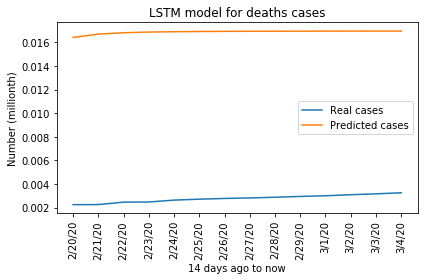

Epoch 0 train loss: 5.506000995635986
Epoch 10 train loss: 3.2056565284729004
Epoch 20 train loss: 1.850317120552063
Epoch 30 train loss: 1.8024442195892334
Epoch 40 train loss: 1.7993974685668945
Epoch 50 train loss: 1.751116156578064
Epoch 60 train loss: 1.7250275611877441
Epoch 70 train loss: 1.6740270853042603
Epoch 80 train loss: 1.6075360774993896
Epoch 90 train loss: 1.5027165412902832
Epoch 100 train loss: 1.2596607208251953
Epoch 110 train loss: 1.0497455596923828


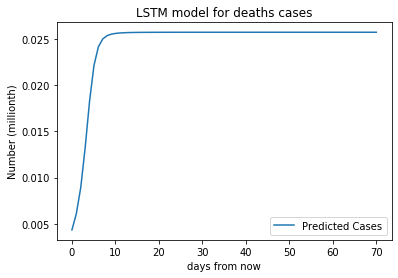

In [30]:
deaths_validation_predicted_cases, deaths_predicted_cases = build_lstm(total_death, name="deaths")


++++++++++++++++++++++++++++++++++++++++++++++++++
Building LSTM model for recovered group.
Epoch 0 train loss: 3.18412446975708 test loss: 47.0784912109375
Epoch 10 train loss: 1.8865320682525635 test loss: 40.2564697265625
Epoch 20 train loss: 1.6975963115692139 test loss: 32.205509185791016
Epoch 30 train loss: 1.5655272006988525 test loss: 34.35734176635742
Epoch 40 train loss: 1.5780967473983765 test loss: 33.05555725097656
Epoch 50 train loss: 1.5569390058517456 test loss: 29.81103515625
Epoch 60 train loss: 1.4815263748168945 test loss: 28.227571487426758
Epoch 70 train loss: 1.4492454528808594 test loss: 23.230072021484375
Epoch 80 train loss: 1.3581793308258057 test loss: 14.76628589630127
Epoch 90 train loss: 1.1296217441558838 test loss: 1.1282662153244019
Epoch 100 train loss: 0.8563178777694702 test loss: 109.85186004638672
Epoch 110 train loss: 0.6893197298049927 test loss: 282.8148193359375


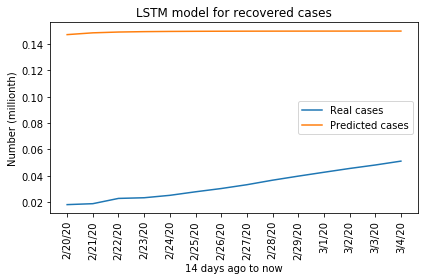

Epoch 0 train loss: 3.078157424926758
Epoch 10 train loss: 1.8554017543792725
Epoch 20 train loss: 1.693336009979248
Epoch 30 train loss: 1.6024386882781982
Epoch 40 train loss: 1.5745303630828857
Epoch 50 train loss: 1.5353548526763916
Epoch 60 train loss: 1.519838809967041
Epoch 70 train loss: 1.4939911365509033
Epoch 80 train loss: 1.4314706325531006
Epoch 90 train loss: 1.2359378337860107
Epoch 100 train loss: 0.9655382037162781
Epoch 110 train loss: 0.7999626398086548


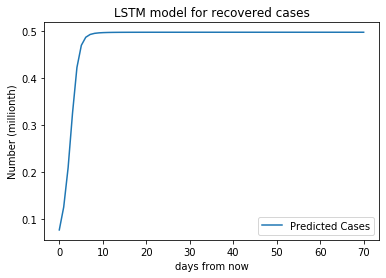

In [31]:
recovered_validation_predicted_cases, recovered_predicted_cases = build_lstm(total_recovered, name="recovered")


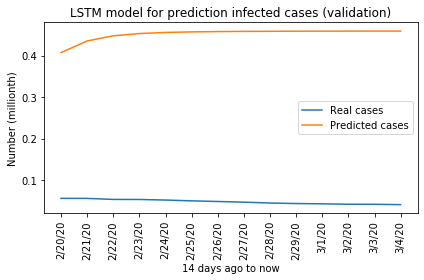

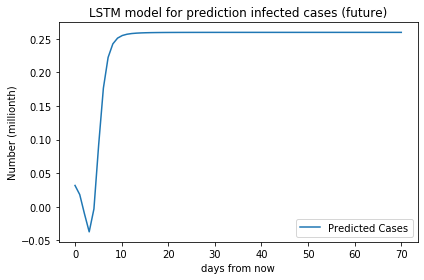

In [32]:
lstm(time_series_data=[total_confirmed, total_death, total_recovered],
     validation_predicted_cases=[confirmed_validation_predicted_cases, deaths_validation_predicted_cases, recovered_validation_predicted_cases],
     predicted_cases=[confirmed_predicted_cases, deaths_predicted_cases, recovered_predicted_cases])


In [14]:
print("#"*100)
# statistical model; ARIMA model, a time-series model.

####################################################################################################
